# Categorical Perception pre-processing
CDF can be plotted using scipy.stats's `logistic` function more info here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.logistic.html

In [2]:
# import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def formant_extractor(vowel_vec):
    '''
    Function to retrieve the f1 values from the stimuli string
    
    INPUTS:
    vowel_vec:      A Pandas Series with the stimuli sting containing the F1 value of the oa vowel

    OUPUT:
    f1_series:      A Panda Series with the F1 values as integers
    '''
    # make sure there are no NaNs
    vowel_vec.dropna(inplace=True)
    # init list of F1 values
    f1_values = []
    # loop through input series and extract F1 values
    for i in range(len(vowel_vec)):
        vowel_string = vowel_vec.iloc[i]
        vowel_string_split = vowel_string.split('_')
        f1_value = int(vowel_string_split[-1][:-4])
        f1_values.append(f1_value)
    f1_series = pd.Series(f1_values)

    return f1_series

def session_data_extractor(ppt_df, session_n):
    '''
    Function to retrieve the data from a given session from a participant's data
    
    INPUTS:
    ppt_df:         A Pandas DataFrame from the raw .csv data from PsychoPy
    session_n:      (Integer) The session number to extract data from

    OUPUT:
    session_n_df:   A Pandas DataFrame with the F1 values, the participant's responses and response times from session n
    '''
    # get series for F1 info, response key and response time
    session_n_str = str(session_n)
    session_n_vowel_vec = ppt_df['session_'+session_n_str+'_vowel']
    session_n_resp_vec = ppt_df['session_'+session_n_str+'_key_resp.keys']
    session_n_resp_time_vec = ppt_df['session_'+session_n_str+'_key_resp.rt']

    # drop NaNs and reset index
    session_n_vowel_vec = session_n_vowel_vec.iloc[session_n_vowel_vec.first_valid_index():session_n_vowel_vec.first_valid_index()+300]
    session_n_resp_vec = session_n_resp_vec.iloc[session_n_resp_vec.first_valid_index():session_n_resp_vec.first_valid_index()+300]
    session_n_resp_time_vec = session_n_resp_time_vec.iloc[session_n_resp_time_vec.first_valid_index():session_n_resp_time_vec.first_valid_index()+300]
    session_n_vowel_vec.reset_index(drop=True, inplace=True); session_n_resp_vec.reset_index(drop=True, inplace=True);session_n_resp_time_vec.reset_index(drop=True, inplace=True)

    # get new series with F1 values as integers
    session_n_f1_vec = formant_extractor(session_n_vowel_vec)

    # get new series with response keys as codes
    # f = 1; j = 0
    session_n_resp_int_vec = session_n_resp_vec.replace(to_replace='f', value=1)
    session_n_resp_int_vec.replace(to_replace='j', value=0, inplace=True)

    session_n_df = pd.concat([session_n_f1_vec, session_n_resp_vec, session_n_resp_int_vec, session_n_resp_time_vec], axis=1)
    session_n_df.columns = ['session_'+session_n_str+'_f1_value',
                            'session_'+session_n_str+'_response_key',
                            'session_'+session_n_str+'_response_code',
                            'session_'+session_n_str+'_response_time']
    return session_n_df

def all_sessions_data_extractor(ppt_df, n_sessions):
    for i in np.arange(1, n_sessions+1):
        if i == 1:
            session_1_df = session_data_extractor(ppt_df, i)
            ppt_processed_df = session_1_df
        else:
            session_i_df = session_data_extractor(ppt_df, i)
            ppt_processed_df = pd.concat([ppt_processed_df, session_i_df], axis=1)
    return ppt_processed_df

def raw_to_processed_df(ppt_df, n_sessions):
    # get ppt meta data
    ppt_id = ppt_df.participant.iloc[0]
    age = ppt_df.age.iloc[0]
    gender = ppt_df.gender.iloc[0]
    language = ppt_df['native language(s)'].iloc[0]
    # get session data
    session_df = all_sessions_data_extractor(ppt_df, n_sessions)
    # get number of observations
    n_observations = session_df.shape[0]
    # concat meta-data and session data
    processed_df = pd.concat([
        pd.Series(np.full(n_observations, ppt_id)),
        pd.Series(np.full(n_observations, age)),
        pd.Series(np.full(n_observations, gender)),
        pd.Series(np.full(n_observations, language)),
        session_df     
    ], axis=1)
    processed_df.rename({0: 'ppt_id', 1: 'age',
                        2: 'gender', 3: 'language'}, axis=1, inplace=True)
    return processed_df

In [4]:
processed_df_i = raw_to_processed_df(ex_ppt_df, 3)
processed_df_i

,ppt_id,age,gender,language,session_1_f1_value,session_1_response_key,session_1_response_code,session_1_response_time,session_2_f1_value,session_2_response_key,session_2_response_code,session_2_response_time,session_3_f1_value,session_3_response_key,session_3_response_code,session_3_response_time
0,Alexandru Suru,24,Male,Romanian,517,f,1,0.627747,664,f,1,0.394948,489,j,0,0.582205
1,Alexandru Suru,24,Male,Romanian,682,f,1,0.539368,593,f,1,0.233644,479,j,0,0.331935
2,Alexandru Suru,24,Male,Romanian,440,j,0,0.500965,517,j,0,0.298235,516,j,0,0.298418
3,Alexandru Suru,24,Male,Romanian,464,j,0,0.551683,663,f,1,0.392561,600,f,1,0.295436
4,Alexandru Suru,24,Male,Romanian,594,f,1,0.380927,639,f,1,0.308769,629,f,1,0.343485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Alexandru Suru,24,Male,Romanian,498,j,0,0.485703,511,j,0,0.304874,494,j,0,0.278057
296,Alexandru Suru,24,Male,Romanian,630,None,None,NaN,446,j,0,0.406621,610,j,0,0.271325
297,Alexandru Suru,24,Male,Romanian,624,f,1,0.439250,466,j,0,0.341399,527,j,0,0.349466
298,Alexandru Suru,24,Male,Romanian,724,f,1,0.356427,561,j,0,0.469264,710,f,1,0.275801


## Process all participants

In [5]:
data_fhands = os.listdir('../data/pilot/raw')
csv_fhands = [fhand for fhand in data_fhands if fhand.endswith('.csv')]
csv_fhands

['Chiheng_Jiang_Alexandru Suru_vowel_discrimination_task_2023_Apr_10_1829.csv',
 'Chiheng_Jiang_dai bo_vowel_discrimination_task_2023_Apr_16_2044.csv',
 'Chiheng_Jiang_Du_vowel_discrimination_task_2023_Apr_13_1547.csv',
 'Chiheng_Jiang_lucy_vowel_discrimination_task_2023_Apr_13_1623.csv',
 'Chiheng_Jiang_Pear_vowel_discrimination_task_2023_Apr_16_2139.csv',
 'Chiheng_Jiang_Raina_vowel_discrimination_task_2023_Apr_11_1914.csv',
 'Chiheng_Jiang_Vicki_vowel_discrimination_task_2023_Apr_14_2309.csv',
 'Chiheng_Jiang_Xinyue Guo_vowel_discrimination_task_2023_Apr_11_1813.csv',
 'Chiheng_Jiang_Yumeng Wang_vowel_discrimination_task_2023_Apr_14_1823.csv',
 'Chiheng_Jiang_yuyang ji_vowel_discrimination_task_2023_Apr_16_2112.csv']

In [9]:
for csv_fhand in csv_fhands:
    raw_ppt_df = pd.read_csv('../data/pilot/raw/'+csv_fhand)
    processed_df_i = raw_to_processed_df(raw_ppt_df, 3)
    processed_df_i.to_csv('../data/pilot/processed/processed_'+csv_fhand, index=False)

## Example data visualisation

In [6]:
data_fhands = os.listdir('../data/pilot/processed/')
csv_fhands = [fhand for fhand in data_fhands if fhand.endswith('.csv')]
processed_csv_fhands = [fhand for fhand in csv_fhands if fhand.startswith('processed_')]

In [7]:
ex_processed_ppt_df = pd.read_csv('../data/pilot/processed/'+processed_csv_fhands[2])
ex_processed_ppt_df.head()

,ppt_id,age,gender,language,session_1_f1_value,session_1_response_key,session_1_response_code,session_1_response_time,session_2_f1_value,session_2_response_key,session_2_response_code,session_2_response_time,session_3_f1_value,session_3_response_key,session_3_response_code,session_3_response_time
0,Du,24,Female,Mandarin,599,f,1,0.770509,653,j,0,0.553958,467,j,0,0.918963
1,Du,24,Female,Mandarin,440,j,0,0.488519,498,j,0,0.532673,555,f,1,0.649283
2,Du,24,Female,Mandarin,679,f,1,0.338925,691,f,1,0.440715,618,f,1,0.475265
3,Du,24,Female,Mandarin,594,f,1,0.360732,632,f,1,0.378208,464,j,0,0.535685
4,Du,24,Female,Mandarin,453,j,0,0.433608,720,f,1,0.836912,561,j,0,0.671678


In [8]:
# drop rows where theres no response in session 1
cleaned_ex_df = ex_processed_ppt_df[ex_processed_ppt_df.session_1_response_code != 'None']
cleaned_ex_df["session_1_response_code"] = cleaned_ex_df["session_1_response_code"].astype(str).astype(int)
cleaned_ex_df

C:\Users\liamb\AppData\Local\Temp/ipykernel_19848/3322685418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ex_df["session_1_response_code"] = cleaned_ex_df["session_1_response_code"].astype(str).astype(int)


,ppt_id,age,gender,language,session_1_f1_value,session_1_response_key,session_1_response_code,session_1_response_time,session_2_f1_value,session_2_response_key,session_2_response_code,session_2_response_time,session_3_f1_value,session_3_response_key,session_3_response_code,session_3_response_time
0,Du,24,Female,Mandarin,599,f,1,0.770509,653,j,0,0.553958,467,j,0,0.918963
1,Du,24,Female,Mandarin,440,j,0,0.488519,498,j,0,0.532673,555,f,1,0.649283
2,Du,24,Female,Mandarin,679,f,1,0.338925,691,f,1,0.440715,618,f,1,0.475265
3,Du,24,Female,Mandarin,594,f,1,0.360732,632,f,1,0.378208,464,j,0,0.535685
4,Du,24,Female,Mandarin,453,j,0,0.433608,720,f,1,0.836912,561,j,0,0.671678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Du,24,Female,Mandarin,475,j,0,0.430751,692,j,0,0.675375,484,j,0,0.548630
296,Du,24,Female,Mandarin,561,j,0,0.530342,590,j,0,0.642238,512,j,0,0.546242
297,Du,24,Female,Mandarin,600,j,0,0.512014,473,j,0,0.750838,483,j,0,0.633701
298,Du,24,Female,Mandarin,598,j,0,0.472591,573,j,0,0.621253,605,j,0,0.694804


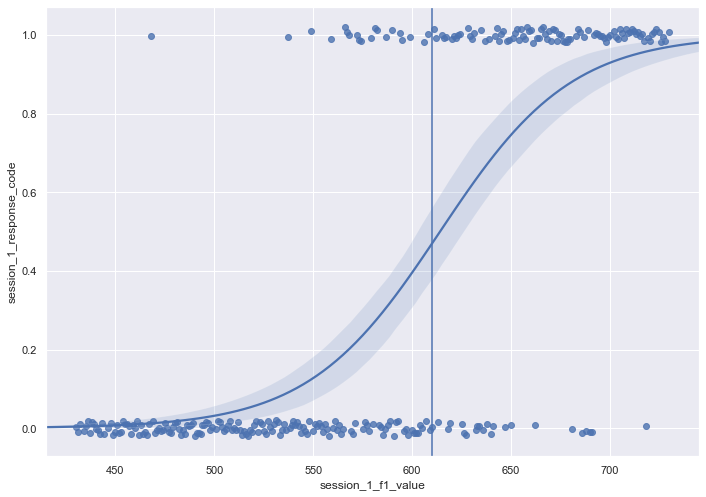

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.regplot(x="session_1_f1_value", y="session_1_response_code", data=cleaned_ex_df,
            y_jitter=.02, logistic=True, truncate=False)
ax = plt.axvline(610)

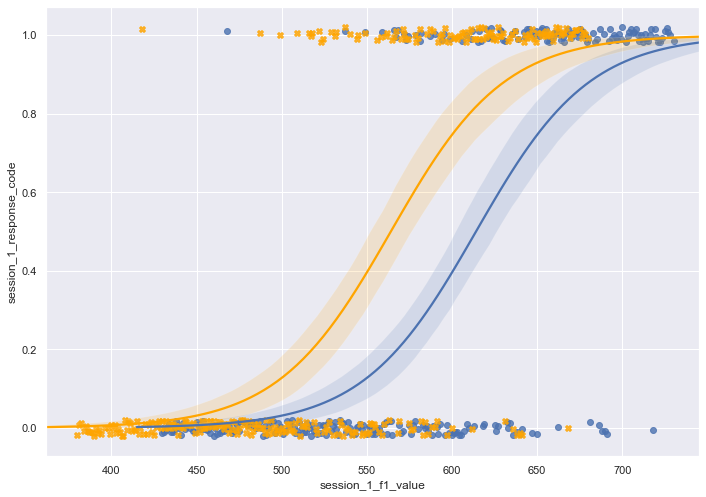

In [13]:
# example of shifted resopnses
shifted_cleaned_ex_series = cleaned_ex_df.session_1_f1_value - 50
ax = sns.regplot(x="session_1_f1_value", y="session_1_response_code", data=cleaned_ex_df,
            y_jitter=.02, logistic=True, truncate=False)
ax = sns.regplot(x=shifted_cleaned_ex_series, y=cleaned_ex_df.session_1_response_code,
                 color='orange', marker="X",
            y_jitter=.02, logistic=True, truncate=False)

c:\Users\l.barrett\AppData\Local\SimNIBS\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


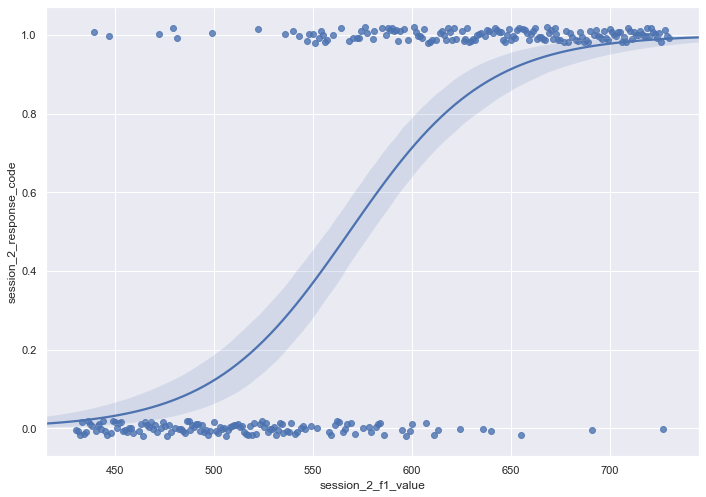

In [21]:
cleaned_ex_df = ex_processed_ppt_df[ex_processed_ppt_df.session_2_response_code != 'None']
cleaned_ex_df["session_2_response_code"] = cleaned_ex_df["session_2_response_code"].astype(str).astype(int)
ax = sns.regplot(x="session_2_f1_value", y="session_2_response_code", data=cleaned_ex_df,
            y_jitter=.02, logistic=True, truncate=False)

c:\Users\l.barrett\AppData\Local\SimNIBS\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


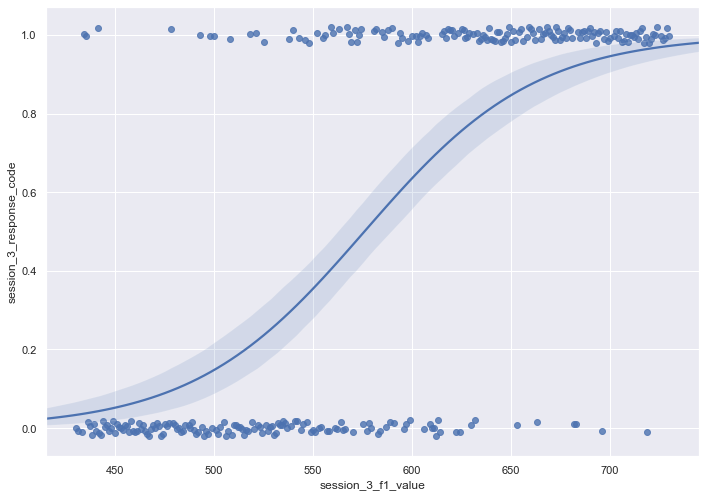

In [22]:
cleaned_ex_df = ex_processed_ppt_df[ex_processed_ppt_df.session_3_response_code != 'None']
cleaned_ex_df["session_3_response_code"] = cleaned_ex_df["session_3_response_code"].astype(str).astype(int)
ax = sns.regplot(x="session_3_f1_value", y="session_3_response_code", data=cleaned_ex_df,
            y_jitter=.02, logistic=True, truncate=False)